In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
os.chdir("/data/phillip_guo/mechanistic-unlearning")

# Multi Run Graphs

In [2]:
colors = {
    "Localized AP": "#1f77b4",     # C0 - blue
    "Localized CT": "#ff7f0e",     # C1 - orange 
    "Localized AP MLPs": "#3498db", # Already hex - light blue
    "Localized CT MLPs": "#f1c40f", # Already hex - yellow
    "Manual Interp": "#d62728",    # C3 - red
    "Random": "#2ca02c",           # C2 - green
    "All MLPs": "#8c564b",         # C5 - brown
    "Non-Localized": "#9467bd",    # C4 - purple
    "Random MLPs": "#e377c2"       # C7 - pink
}

In [3]:
localization_types = {"localized_ap": "Localized AP", "localized_ct": "Localized CT", "localized_ap_mlps": "Localized AP MLPs", "localized_ct_mlps": "Localized CT MLPs", "manual_interp": "Manual Interp", "random": "Random", "all_mlps": "All MLPs", "nonlocalized": "Non-Localized", "random_mlps": "Random MLPs"}
# model_names = {"llama3": "Llama 3 8b"} # "gemma": "Gemma 7b", "gemma2": "Gemma 2 9b", 
# forget_splits = {"16": "16 Random Athletes", "64": "64 Random Athletes"}
# inject_labels = {"random_without_golf": "Random (No Golf)"}

# model_names = {"gemma": "Gemma 7b", "gemma2": "Gemma 2 9b", "llama3": "Llama 3 8b"} #  
# forget_splits = {"16": "16 Facts", "64": "64 Facts"}
# inject_labels = {"": "Inject"}
# run_ids = ["1"]
# final_epoch = 49
# fig_save_name = "counterfactedit"

model_names = {"gemma": "Gemma 7b", "gemma2": "Gemma 2 9b", "llama3": "Llama 3 8b"} #  
forget_splits = {"64": "64 Facts"}
inject_labels = {"_sequential": "Injecting Sequentially"}
run_ids = ["1"]
final_epoch = 99
fig_save_name = "counterfactsequentialedit"


import itertools
configs = list(itertools.product(model_names, forget_splits, inject_labels, run_ids))



# average over forget splits, inject labels, model names, and run_ids. For singular results, have only single elements


test_losses_list = []
adversarial_evals_list = []
# side_effects_evals_list = []
mmlu_evals_list = []

do_probing_evals = False
probing_evals_list = []

do_relearning_evals = True
relearning_evals_list = []

do_softprompt_evals = True
softprompt_evals_list = []

for localization_type in localization_types:
    aggregated_results = []
    # Convert iterator to list and wrap with tqdm for proper progress tracking
    for model_name, forget_split, inject_label, run_id in tqdm(configs, desc=f"Processing {localization_type}"):
        config_dir = {"localization_type": localization_types[localization_type], "model_name": model_name, "forget_split": forget_splits[forget_split], "inject_label": inject_labels[inject_label], "run_id": run_id}

        save_dir = f"results_rebuttal_counterfact/{model_name}_forget_{forget_split}_inject{inject_label}/{localization_type}_run{run_id}"
        with open(f"{save_dir}/models/model_metrics.pkl", "rb") as f:
            model_metrics = pickle.load(f)

        for task, value in model_metrics["test_losses"].items():
            test_losses_list.append({
                **config_dir,
                "task_name": task,
                "test_loss": value[-1]
            })
        
        for eval_type, results in model_metrics["adversarial_evals"][final_epoch].items():
            adversarial_evals_list.append({
                **config_dir,
                "eval_type": eval_type,
                "forget": results["forget"],
                "maintain": results["maintain"]
            })
        
        with open(f"{save_dir}/full_capability_dict.pkl", "rb") as f:
            full_capability_dict = pickle.load(f)
        
        mmlu_evals_list.append({
            **config_dir,
            "mmlu": full_capability_dict["results"]["mmlu"]["acc,none"]
        })

        if do_probing_evals:
            with open(f"{save_dir}/results/probing_results.pkl", "rb") as f:
                probing_results = pickle.load(f)
            for layer in range(len(probing_results["forget_ground_truth_accs"])):
                probing_evals_list.append({
                    **config_dir,
                    "layer": layer,
                    "forget_ground_truth_acc": probing_results["forget_ground_truth_accs"][layer],
                    "forget_edit_acc": probing_results["forget_edit_accs"][layer],
                    "maintain_train_acc": probing_results["maintain_train_accs"][layer],
                    "maintain_test_acc": probing_results["maintain_test_accs"][layer]
                })


        if do_relearning_evals:
            with open(f"{save_dir}/results/relearning_results.pkl", "rb") as f:
                relearning_results = pickle.load(f)
            for step in range(len(relearning_results["relearning_test_losses"])):
                relearning_dict = relearning_results["relearning_test_losses"][step]
                if len(relearning_dict) > 0:
                    current_dict = {
                        **config_dir,
                        "step": step,
                        "mmlu": relearning_dict["MMLU"]["MMLU"]
                    }
                    for adversarial_eval_type in relearning_dict["adversarial"].keys():
                        for split in ["forget", "maintain"]:
                            current_dict[f"{adversarial_eval_type}_{split}"] = relearning_dict["adversarial"][adversarial_eval_type][split]
                    relearning_evals_list.append(current_dict)
        
        if do_softprompt_evals:
            with open(f"{save_dir}/results/softprompt_metrics.pkl", "rb") as f:
                softprompt_results = pickle.load(f)
            
            for softprompt_iter in range(len(softprompt_results)):
                softprompt_evals_list.append({
                    **config_dir,
                    "softprompt_iter": softprompt_iter,
                    "forget_acc": softprompt_results[softprompt_iter]["forget_acc"],
                    "forget_acc_with_injected": softprompt_results[softprompt_iter]["forget_acc_with_injected"],
                    "maintain_acc": softprompt_results[softprompt_iter]["maintain_acc"]
                })
            # for task_name, task_split in [("Normal", "forget"), ("MC", "forget")]:
            #     softprompt_evals_list.append({

Processing localized_ap:   0%|          | 0/3 [00:00<?, ?it/s]

Processing localized_ct:   0%|          | 0/3 [00:00<?, ?it/s]

Processing localized_ap_mlps:   0%|          | 0/3 [00:00<?, ?it/s]

Processing localized_ct_mlps:   0%|          | 0/3 [00:00<?, ?it/s]

Processing manual_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Processing random:   0%|          | 0/3 [00:00<?, ?it/s]

Processing all_mlps:   0%|          | 0/3 [00:00<?, ?it/s]

Processing nonlocalized:   0%|          | 0/3 [00:00<?, ?it/s]

Processing random_mlps:   0%|          | 0/3 [00:00<?, ?it/s]

## Train/Test Statistics

In [4]:
# convert all to dataframes
test_losses_df = pd.DataFrame(test_losses_list)
adversarial_evals_df = pd.DataFrame(adversarial_evals_list)
mmlu_evals_df = pd.DataFrame(mmlu_evals_list)
if do_probing_evals:
    probing_evals_df = pd.DataFrame(probing_evals_list)
if do_relearning_evals:
    relearning_evals_df = pd.DataFrame(relearning_evals_list)
if do_softprompt_evals:
    softprompt_evals_df = pd.DataFrame(softprompt_evals_list)

### Test Evals

In [5]:
test_losses_df

,localization_type,model_name,forget_split,inject_label,run_id,task_name,test_loss
0,Localized AP,gemma,64 Facts,Injecting Sequentially,1,pile,2.450993
1,Localized AP,gemma,64 Facts,Injecting Sequentially,1,pile_accuracy,0.522006
2,Localized AP,gemma,64 Facts,Injecting Sequentially,1,forget_fact,0.463914
3,Localized AP,gemma,64 Facts,Injecting Sequentially,1,forget_fact_accuracy,0.144409
4,Localized AP,gemma,64 Facts,Injecting Sequentially,1,maintain_fact,0.861241
...,...,...,...,...,...,...,...
184,Random MLPs,llama3,64 Facts,Injecting Sequentially,1,forget_fact,0.408052
185,Random MLPs,llama3,64 Facts,Injecting Sequentially,1,forget_fact_accuracy,0.084522
186,Random MLPs,llama3,64 Facts,Injecting Sequentially,1,maintain_fact,0.272054
187,Random MLPs,llama3,64 Facts,Injecting Sequentially,1,maintain_fact_accuracy,0.893519


In [6]:
test_losses_df[test_losses_df["task_name"].isin(["forget_fact_accuracy", "maintain_fact_accuracy"])].groupby(["localization_type", "task_name"]).mean(numeric_only=True)

test_loss
localization_type task_name                        
All MLPs          forget_fact_accuracy     0.059370
                  maintain_fact_accuracy   0.947920
Localized AP      forget_fact_accuracy     0.176605
                  maintain_fact_accuracy   0.886207
Localized AP MLPs forget_fact_accuracy     0.194194
                  maintain_fact_accuracy   0.921791
Localized CT      forget_fact_accuracy     0.130004
                  maintain_fact_accuracy   0.917301
Localized CT MLPs forget_fact_accuracy     0.123275
                  maintain_fact_accuracy   0.927639
Manual Interp     forget_fact_accuracy     0.033863
                  maintain_fact_accuracy   0.900353
Non-Localized     forget_fact_accuracy     0.083382
                  maintain_fact_accuracy   0.932666
Random            forget_fact_accuracy     0.127124
                  maintain_fact_accuracy   0.865139
Random MLPs       forget_fact_accuracy     0.092967
                  maintain_fact_accuracy   0.923586

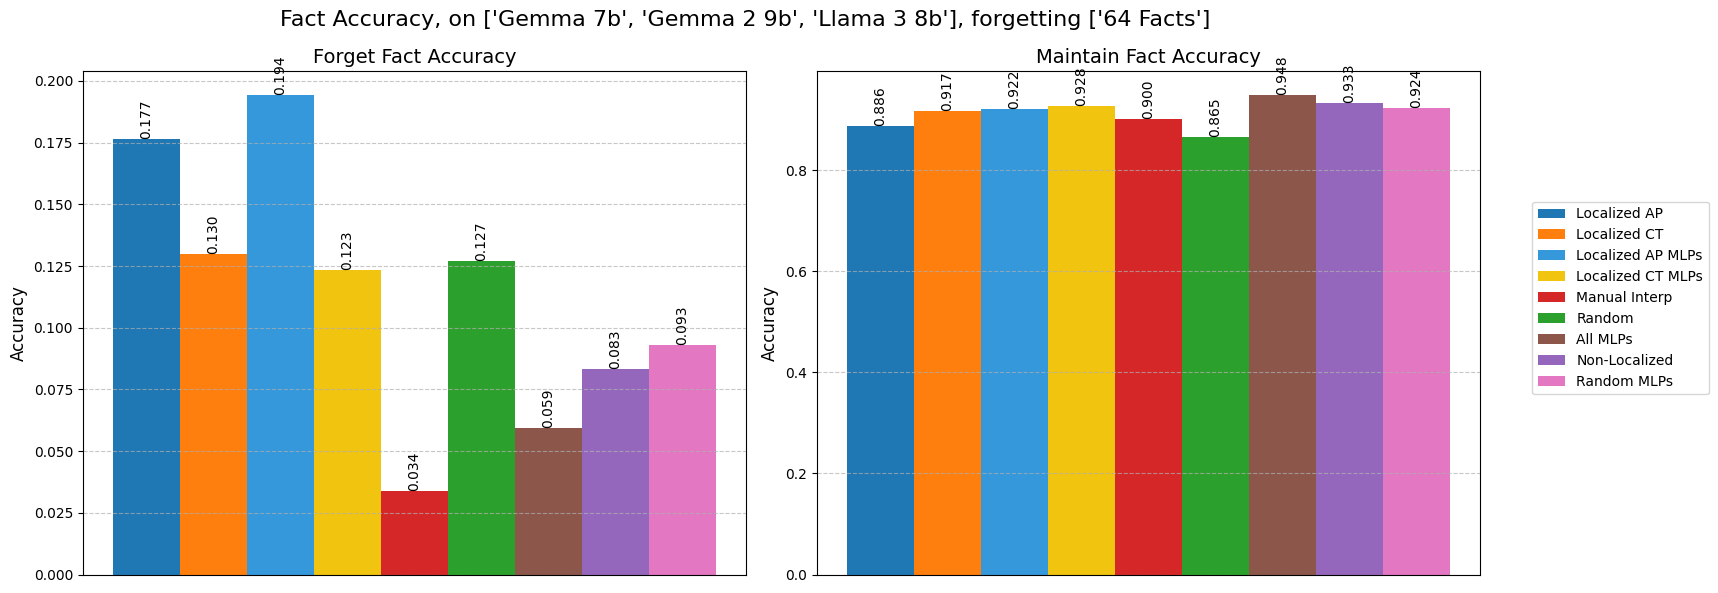

In [7]:
# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

loc_types = test_losses_df['localization_type'].unique()
width = 0.12
x = np.arange(1)  # Only one bar position per subplot

# Plot Forget Sport Accuracy
for idx, loc_type in enumerate(loc_types):
    data = test_losses_df[test_losses_df['localization_type'] == loc_type]
    forget_acc = data[data['task_name'] == 'forget_fact_accuracy']['test_loss'].mean()
    
    # Calculate bar position
    bar_position = x + idx*width - (len(loc_types)-1)*width/2
    
    # Create bar
    bar = ax1.bar(bar_position, forget_acc, width, label=loc_type, color=colors[loc_type])
    
    # Add value label
    ax1.text(bar_position[0], forget_acc, f'{forget_acc:.3f}',
             ha='center', va='bottom', rotation=90)

# Plot Maintain Sport Accuracy
for idx, loc_type in enumerate(loc_types):
    data = test_losses_df[test_losses_df['localization_type'] == loc_type]
    maintain_acc = data[data['task_name'] == 'maintain_fact_accuracy']['test_loss'].mean()
    
    # Calculate bar position
    bar_position = x + idx*width - (len(loc_types)-1)*width/2
    
    # Create bar
    bar = ax2.bar(bar_position, maintain_acc, width, label=loc_type, color=colors[loc_type])
    
    # Add value label
    ax2.text(bar_position[0], maintain_acc, f'{maintain_acc:.3f}',
             ha='center', va='bottom', rotation=90)

# Customize plots
ax1.set_ylabel('Accuracy', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Forget Fact Accuracy', fontsize=14)
ax2.set_title('Maintain Fact Accuracy', fontsize=14)
plt.suptitle(f"Fact Accuracy, on {list(model_names.values())}, forgetting {list(forget_splits.values())}", fontsize=16)

# Remove x ticks
ax1.set_xticks([])
ax2.set_xticks([])

# Add grid
ax1.grid(True, linestyle='--', alpha=0.7)
ax2.grid(True, linestyle='--', alpha=0.7)

# Add single legend to the right
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

### Adversarial Evals

In [8]:
adversarial_evals_df.groupby(["localization_type", "eval_type"]).mean(numeric_only=True)

forget  maintain
localization_type eval_type                                
All MLPs          MC                     0.712056  0.921331
                  MC_Injected            0.178676  0.015144
                  Neighborhood           0.508452  0.550169
                  Neighborhood_Injected  0.054782  0.018599
                  Normal                 0.054505  0.936432
...                                           ...       ...
Random MLPs       Neighborhood_Injected  0.060674  0.016364
                  Normal                 0.106288  0.930198
                  Normal_Injected        0.874388  0.008024
                  Paraphrase             0.203199  0.669290
                  Paraphrase_Injected    0.589432  0.010218

[72 rows x 2 columns]

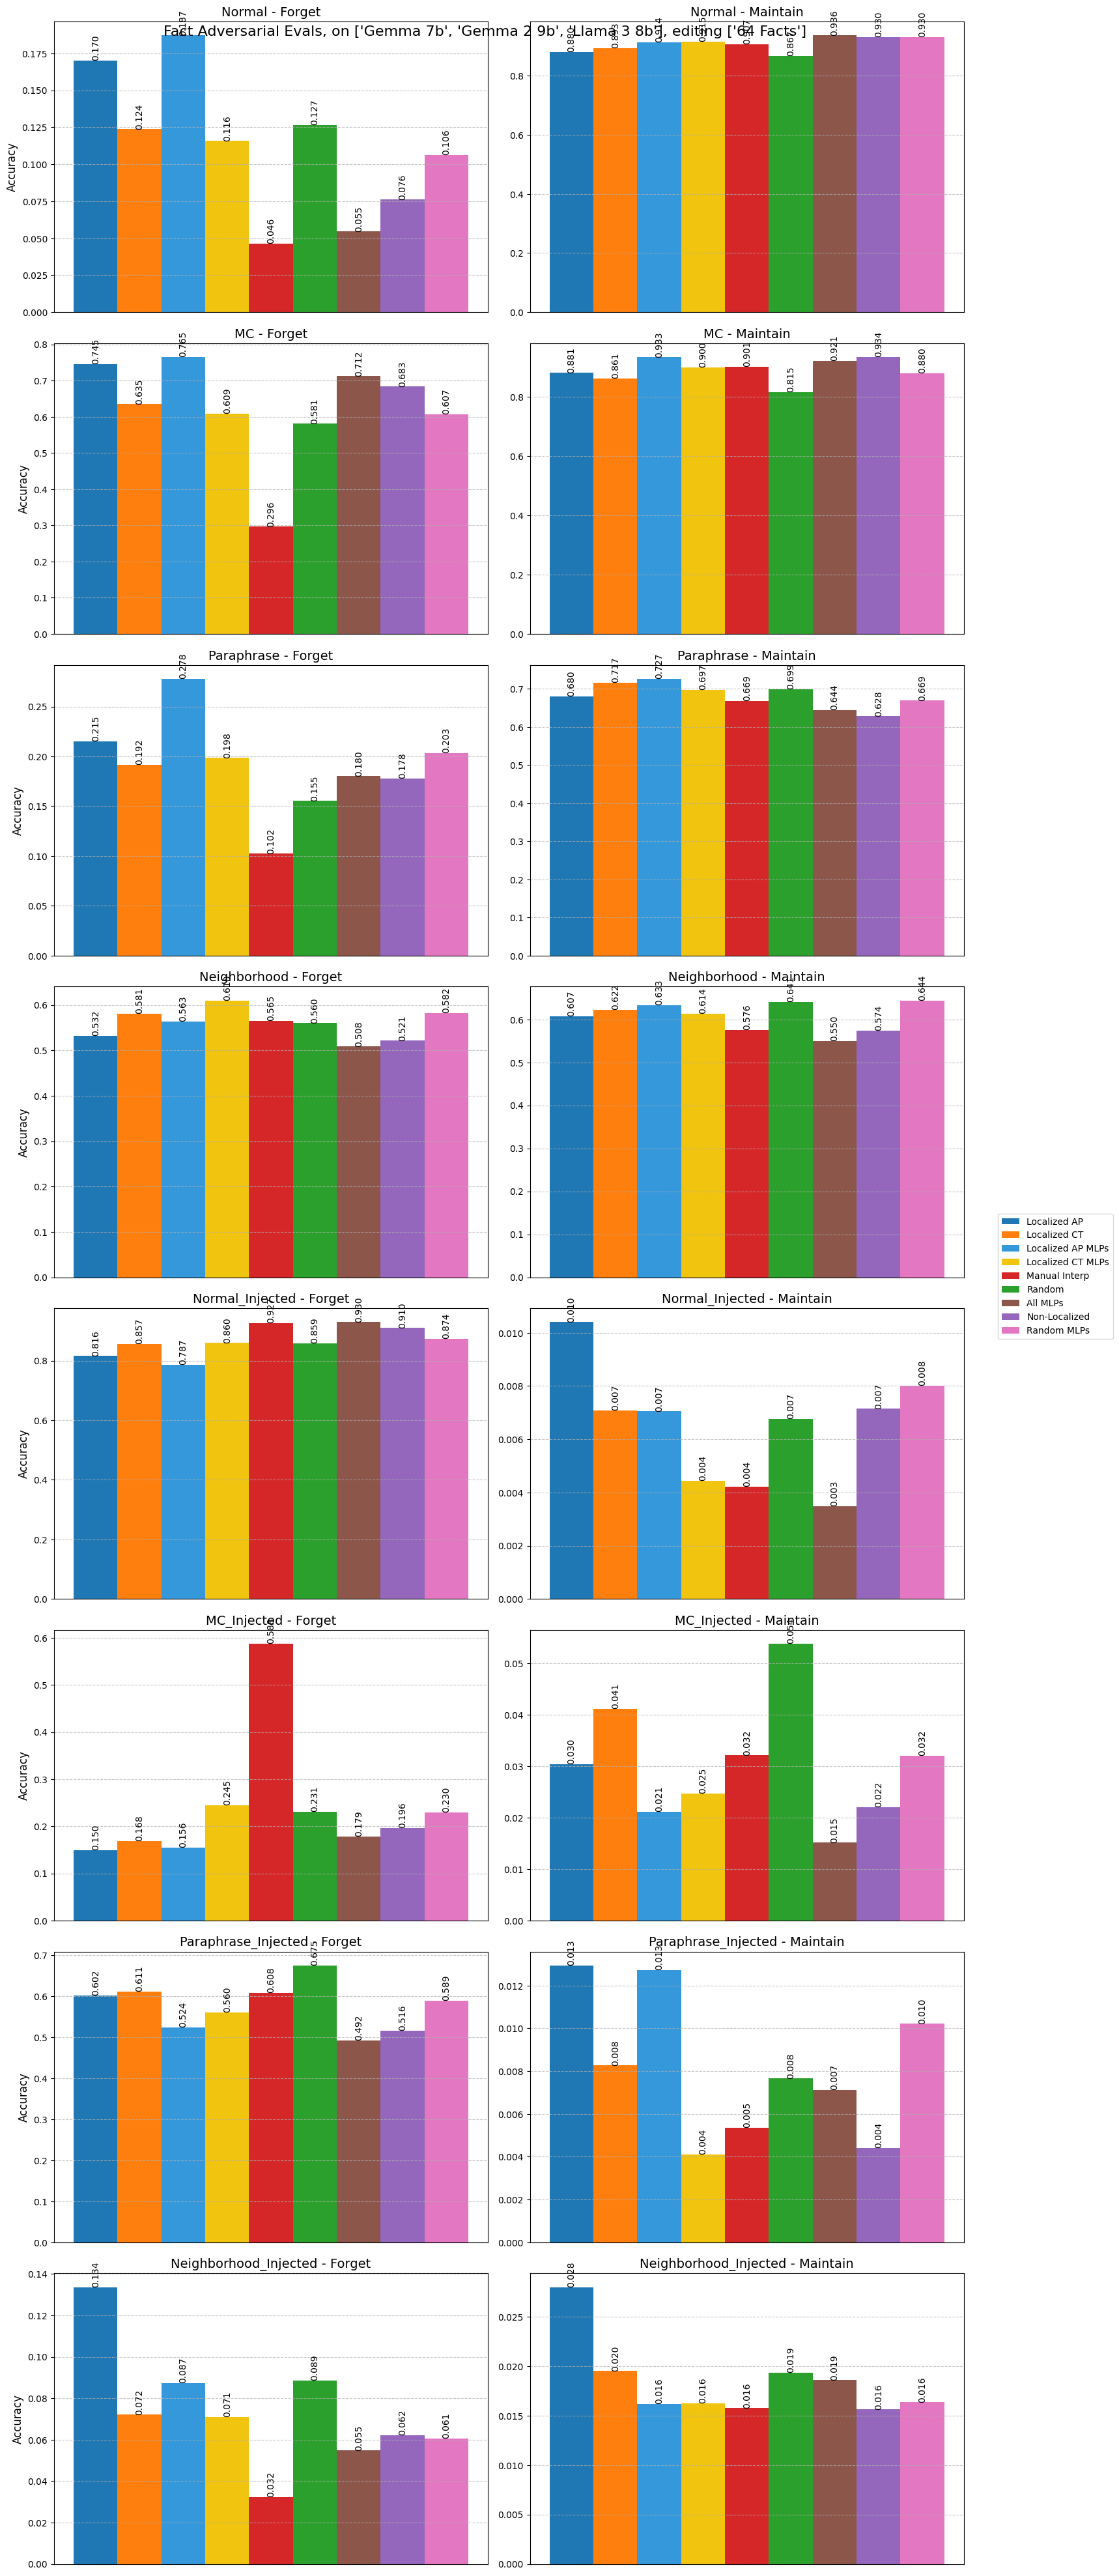

In [9]:
# Create figure and subplots - one row for each eval_type
eval_types = adversarial_evals_df['eval_type'].unique()
fig, axes = plt.subplots(len(eval_types), 2, figsize=(15, 5*len(eval_types)))

loc_types = adversarial_evals_df['localization_type'].unique()
width = 0.12
x = np.arange(1)  # Single bar position per subplot

# Plot each eval_type in a row
for row_idx, eval_type in enumerate(eval_types):
    data = adversarial_evals_df[adversarial_evals_df['eval_type'] == eval_type]
    
    # Plot Forget Accuracy (left column)
    for idx, loc_type in enumerate(loc_types):
        loc_data = data[data['localization_type'] == loc_type]
        forget_acc = loc_data['forget'].mean()
        
        # Calculate bar position
        bar_position = x + idx*width - (len(loc_types)-1)*width/2
        
        # Create bar
        bar = axes[row_idx, 0].bar(bar_position, forget_acc, width, 
                                  label=loc_type, color=colors[loc_type])
        
        # Add value label
        axes[row_idx, 0].text(bar_position[0], forget_acc, f'{forget_acc:.3f}',
                             ha='center', va='bottom', rotation=90)
    
    # Plot Maintain Accuracy (right column)
    for idx, loc_type in enumerate(loc_types):
        loc_data = data[data['localization_type'] == loc_type]
        maintain_acc = loc_data['maintain'].mean()
        
        # Calculate bar position
        bar_position = x + idx*width - (len(loc_types)-1)*width/2
        
        # Create bar
        bar = axes[row_idx, 1].bar(bar_position, maintain_acc, width, 
                                  label=loc_type, color=colors[loc_type])
        
        # Add value label
        axes[row_idx, 1].text(bar_position[0], maintain_acc, f'{maintain_acc:.3f}',
                             ha='center', va='bottom', rotation=90)
    
    # Customize each subplot
    axes[row_idx, 0].set_ylabel('Accuracy', fontsize=12)
    axes[row_idx, 0].set_title(f'{eval_type} - Forget', fontsize=14)
    axes[row_idx, 1].set_title(f'{eval_type} - Maintain', fontsize=14)
    
    # Remove x ticks
    axes[row_idx, 0].set_xticks([])
    axes[row_idx, 1].set_xticks([])
    
    # Add grid
    axes[row_idx, 0].grid(True, linestyle='--', alpha=0.7)
    axes[row_idx, 1].grid(True, linestyle='--', alpha=0.7)

# Add single legend to the right
plt.suptitle(f"Fact Adversarial Evals, on {list(model_names.values())}, editing {list(forget_splits.values())}", fontsize=16)
handles, labels = axes[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

### MMLU Evals

In [10]:
mmlu_evals_df.groupby("localization_type").mean(numeric_only=True)

,mmlu
localization_type,
All MLPs,0.643807
Localized AP,0.630679
Localized AP MLPs,0.634644
Localized CT,0.627214
Localized CT MLPs,0.633718
Manual Interp,0.633979
Non-Localized,0.642074
Random,0.622680
Random MLPs,0.636448


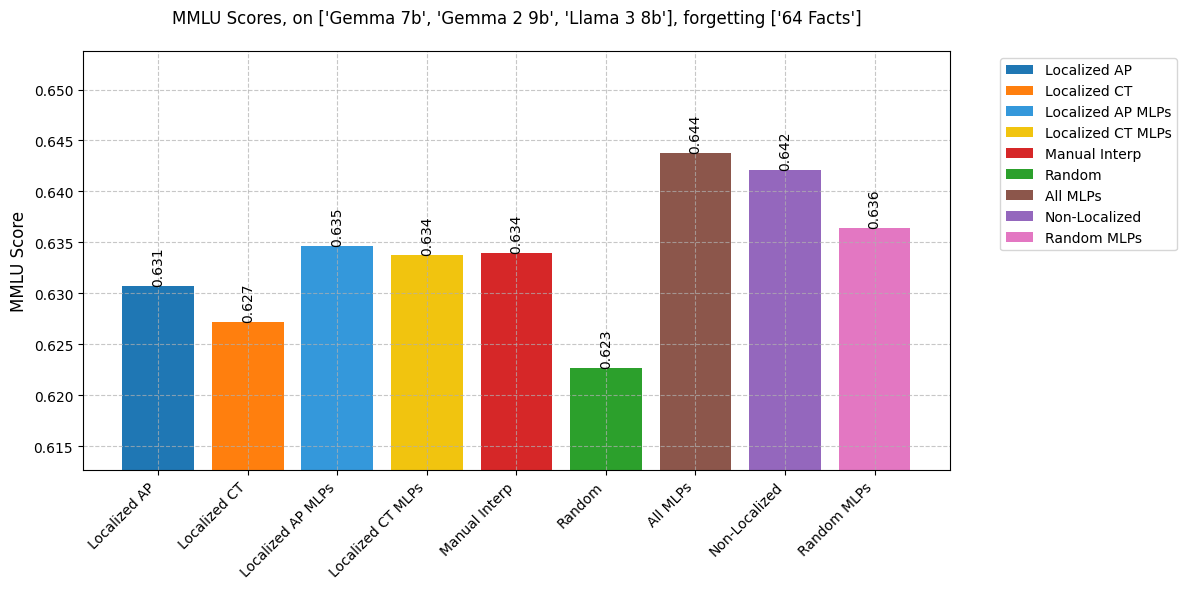

In [11]:
# Create figure
plt.figure(figsize=(12, 6))

# Get data
loc_types = mmlu_evals_df['localization_type'].unique()
mmlu_scores = [mmlu_evals_df[mmlu_evals_df['localization_type'] == loc_type]['mmlu'].mean() 
               for loc_type in loc_types]

# Create bars
bars = plt.bar(range(len(loc_types)), mmlu_scores, color=[colors[loc_type] for loc_type in loc_types])

# Add value labels above each bar
for idx, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', rotation=90)

# Customize plot
plt.ylabel('MMLU Score', fontsize=12)
plt.title(f'MMLU Scores, on {list(model_names.values())}, forgetting {list(forget_splits.values())}', fontsize=12, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis labels
plt.xticks(range(len(loc_types)), loc_types, rotation=45, ha='right')

# Set y-axis limits
min_score = min(mmlu_scores) - 0.01
max_score = max(mmlu_scores) + 0.01
plt.ylim(min_score, max_score)

# Add legend
plt.legend(bars, loc_types, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

plt.show()

### Softprompt Evals

In [12]:
softprompt_evals_df.groupby(["localization_type"]).mean(numeric_only=True).drop("softprompt_iter", axis=1)

,forget_acc,forget_acc_with_injected,maintain_acc
localization_type,,,
All MLPs,0.363446,0.332130,0.672575
Localized AP,0.178707,0.553364,0.596682
Localized AP MLPs,0.244681,0.596309,0.664958
Localized CT,0.204236,0.563855,0.590802
Localized CT MLPs,0.292087,0.470386,0.610551
Manual Interp,0.254705,0.510825,0.606491
Non-Localized,0.338802,0.400346,0.632375
Random,0.192744,0.552148,0.575370
Random MLPs,0.243690,0.581101,0.642914


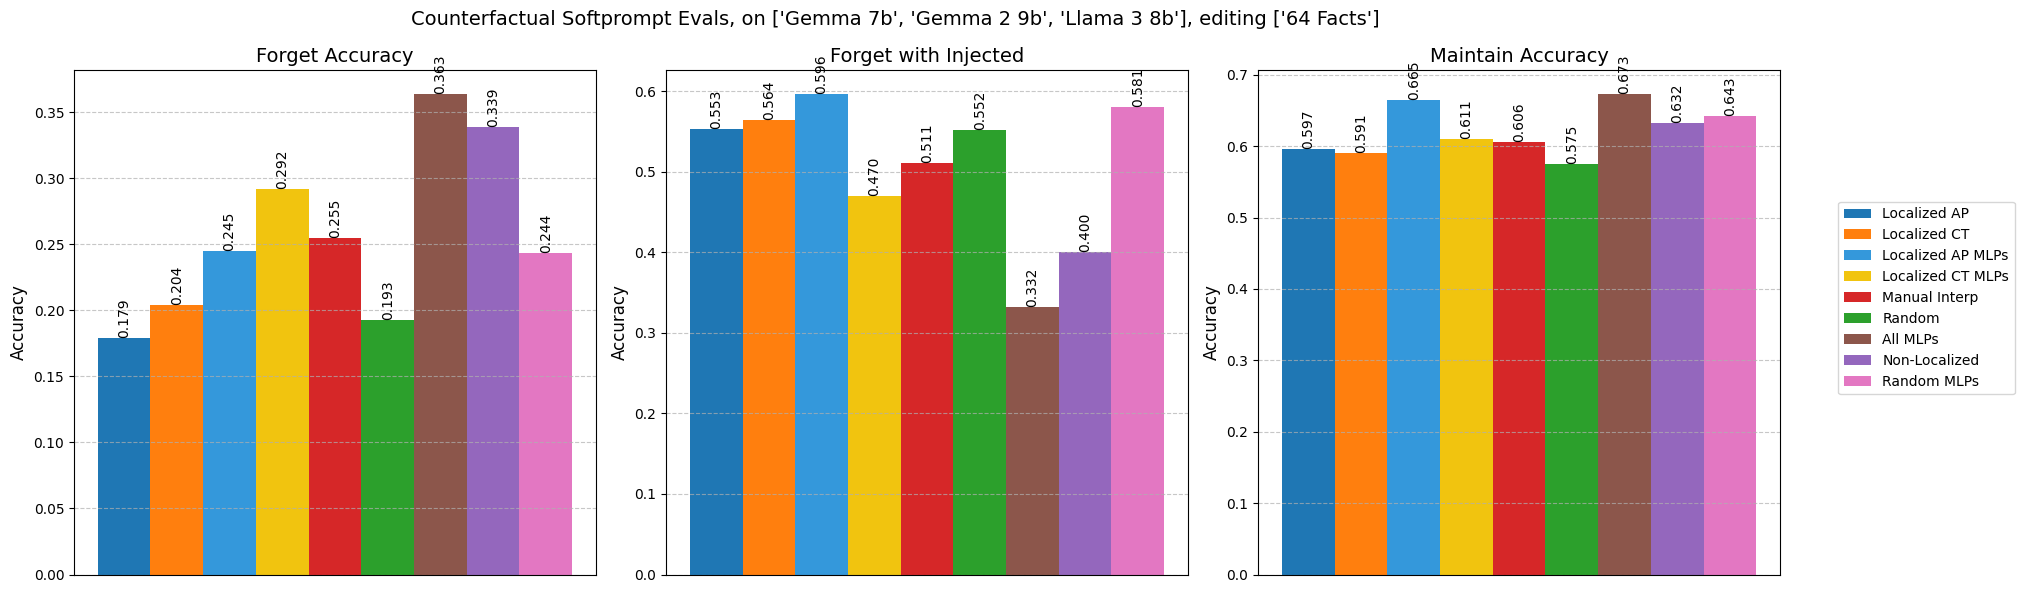

In [13]:
# Create figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

loc_types = softprompt_evals_df['localization_type'].unique()
width = 0.12
x = np.arange(1)  # Single bar position per subplot

# Plot Forget Accuracy
for idx, loc_type in enumerate(loc_types):
    data = softprompt_evals_df[softprompt_evals_df['localization_type'] == loc_type]
    forget_acc = data['forget_acc'].mean()
    
    # Calculate bar position
    bar_position = x + idx*width - (len(loc_types)-1)*width/2
    
    # Create bar
    bar = ax1.bar(bar_position, forget_acc, width, label=loc_type, color=colors[loc_type])
    
    # Add value label
    ax1.text(bar_position[0], forget_acc, f'{forget_acc:.3f}',
             ha='center', va='bottom', rotation=90)

# Plot Forget with Injected Accuracy
for idx, loc_type in enumerate(loc_types):
    data = softprompt_evals_df[softprompt_evals_df['localization_type'] == loc_type]
    forget_injected_acc = data['forget_acc_with_injected'].mean()
    
    # Calculate bar position
    bar_position = x + idx*width - (len(loc_types)-1)*width/2
    
    # Create bar
    bar = ax2.bar(bar_position, forget_injected_acc, width, label=loc_type, color=colors[loc_type])
    
    # Add value label
    ax2.text(bar_position[0], forget_injected_acc, f'{forget_injected_acc:.3f}',
             ha='center', va='bottom', rotation=90)

# Plot Maintain Accuracy
for idx, loc_type in enumerate(loc_types):
    data = softprompt_evals_df[softprompt_evals_df['localization_type'] == loc_type]
    maintain_acc = data['maintain_acc'].mean()
    
    # Calculate bar position
    bar_position = x + idx*width - (len(loc_types)-1)*width/2
    
    # Create bar
    bar = ax3.bar(bar_position, maintain_acc, width, label=loc_type, color=colors[loc_type])
    
    # Add value label
    ax3.text(bar_position[0], maintain_acc, f'{maintain_acc:.3f}',
             ha='center', va='bottom', rotation=90)

# Customize plots
for ax, title in zip([ax1, ax2, ax3], ['Forget Accuracy', 'Forget with Injected', 'Maintain Accuracy']):
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks([])
    ax.grid(True, linestyle='--', alpha=0.7)

# Add single legend to the right
handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left')
plt.suptitle(f"Counterfactual Softprompt Evals, on {list(model_names.values())}, editing {list(forget_splits.values())}", fontsize=14)
# Adjust layout
plt.tight_layout()

plt.show()

### Relearning Evals

In [14]:
relearning_evals_df.groupby(["localization_type", "step"]).mean(numeric_only=True)[["Normal_Injected_forget", "MC_Injected_forget"]]

Normal_Injected_forget  MC_Injected_forget
localization_type step                                            
All MLPs          0                   0.987717            0.177775
                  10                  0.453989            0.196103
                  20                  0.527540            0.199746
Localized AP      0                   0.967856            0.120899
                  10                  0.615875            0.159054
                  20                  0.665856            0.170739
Localized AP MLPs 0                   0.958390            0.116886
                  10                  0.637176            0.153477
                  20                  0.660431            0.170477
Localized CT      0                   0.986906            0.167879
                  10                  0.617746            0.177969
                  20                  0.650978            0.190955
Localized CT MLPs 0                   0.973429            0.225513
                  10                  0.506910            0.232001
                  20                  0.556404            0.247015
Manual Interp     0                   0.983434            0.620077
                  10                  0.447140            0.532831
                  20                  0.534059            0.532104
Non-Localized     0                   0.990986            0.197350
                  10                  0.492094            0.204782
                  20                  0.544047            0.206325
Random            0                   0.981696            0.240352
                  10                  0.539487            0.241710
                  20                  0.586299            0.249603
Random MLPs       0                   0.981807            0.263622
                  10                  0.442127            0.245798
                  20                  0.566579            0.249864

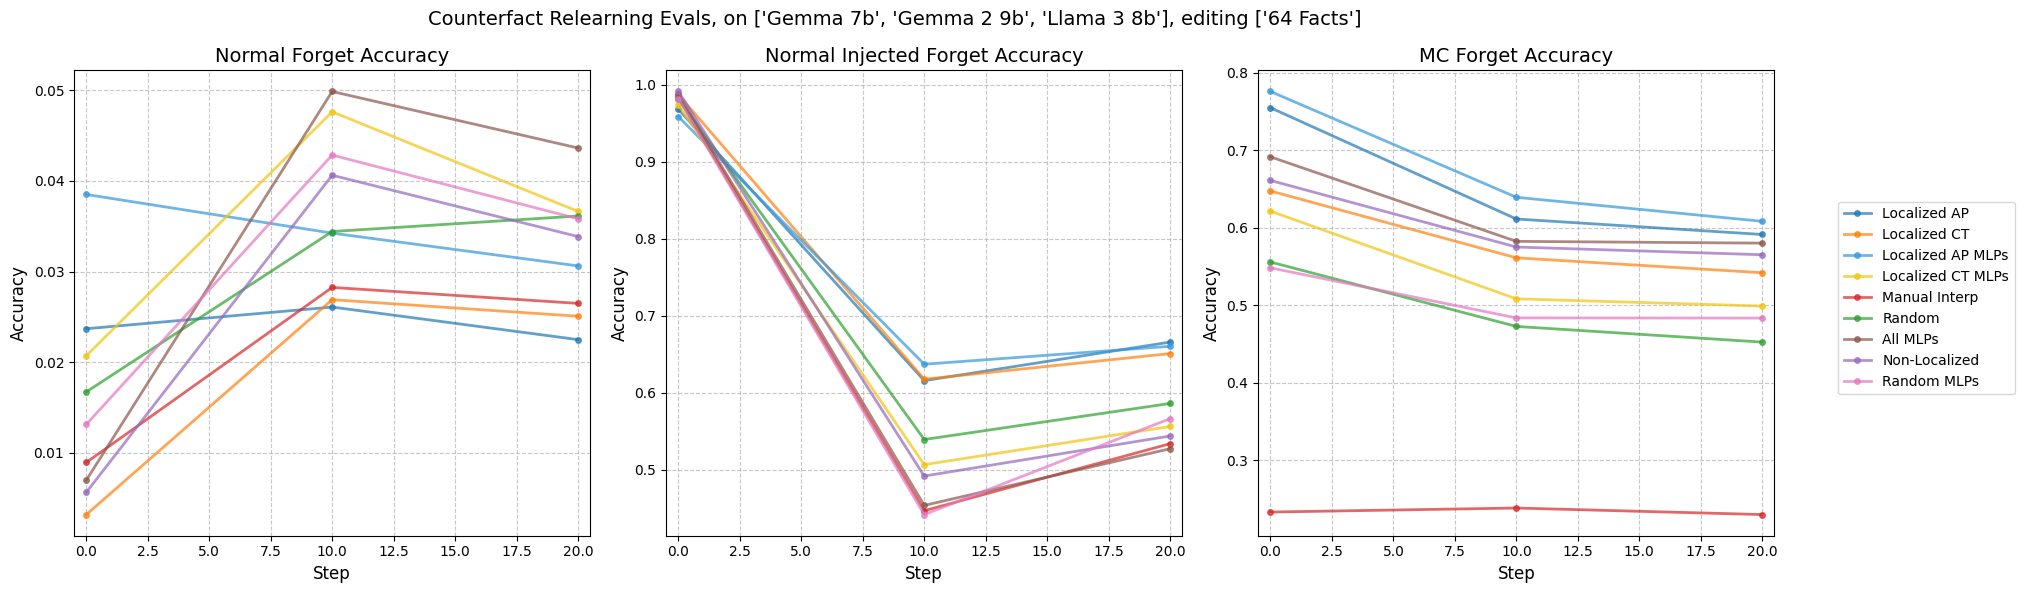

In [15]:
# Create figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

loc_types = relearning_evals_df['localization_type'].unique()
steps = relearning_evals_df['step'].unique()

# Plot Normal Forget
for loc_type in loc_types:
    data = relearning_evals_df[relearning_evals_df['localization_type'] == loc_type]
    normal_forget_vals = [data[data['step'] == step]['Normal_forget'].mean() 
                           for step in steps]
    
    ax1.plot(steps, normal_forget_vals, 'o-', label=loc_type, 
             color=colors[loc_type], alpha=0.7, markersize=4, linewidth=2)

# Plot Normal Injected Forget
for loc_type in loc_types:
    data = relearning_evals_df[relearning_evals_df['localization_type'] == loc_type]
    normal_injected_forget_vals = [data[data['step'] == step]['Normal_Injected_forget'].mean() 
                           for step in steps]
    
    ax2.plot(steps, normal_injected_forget_vals, 'o-', label=loc_type, 
             color=colors[loc_type], alpha=0.7, markersize=4, linewidth=2)

# Plot MC Injected Forget
for loc_type in loc_types:
    data = relearning_evals_df[relearning_evals_df['localization_type'] == loc_type]
    mc_forget_vals = [data[data['step'] == step]['MC_forget'].mean() 
                        for step in steps]
    
    ax3.plot(steps, mc_forget_vals, 'o-', label=loc_type, 
             color=colors[loc_type], alpha=0.7, markersize=4, linewidth=2)

# Customize plots
for ax, title in zip([ax1, ax2, ax3], ['Normal Forget Accuracy', 'Normal Injected Forget Accuracy', 'MC Forget Accuracy']):
    ax.set_xlabel('Step', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlim(-0.5, max(steps)+0.5)

# Add single legend to the right
handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left')
plt.suptitle(f"Counterfact Relearning Evals, on {list(model_names.values())}, editing {list(forget_splits.values())}", fontsize=14)
# Adjust layout
plt.tight_layout()

plt.show()

## Paper Graphs

### Bars

Accuracies After Sequentially Editing 64 CounterFact facts


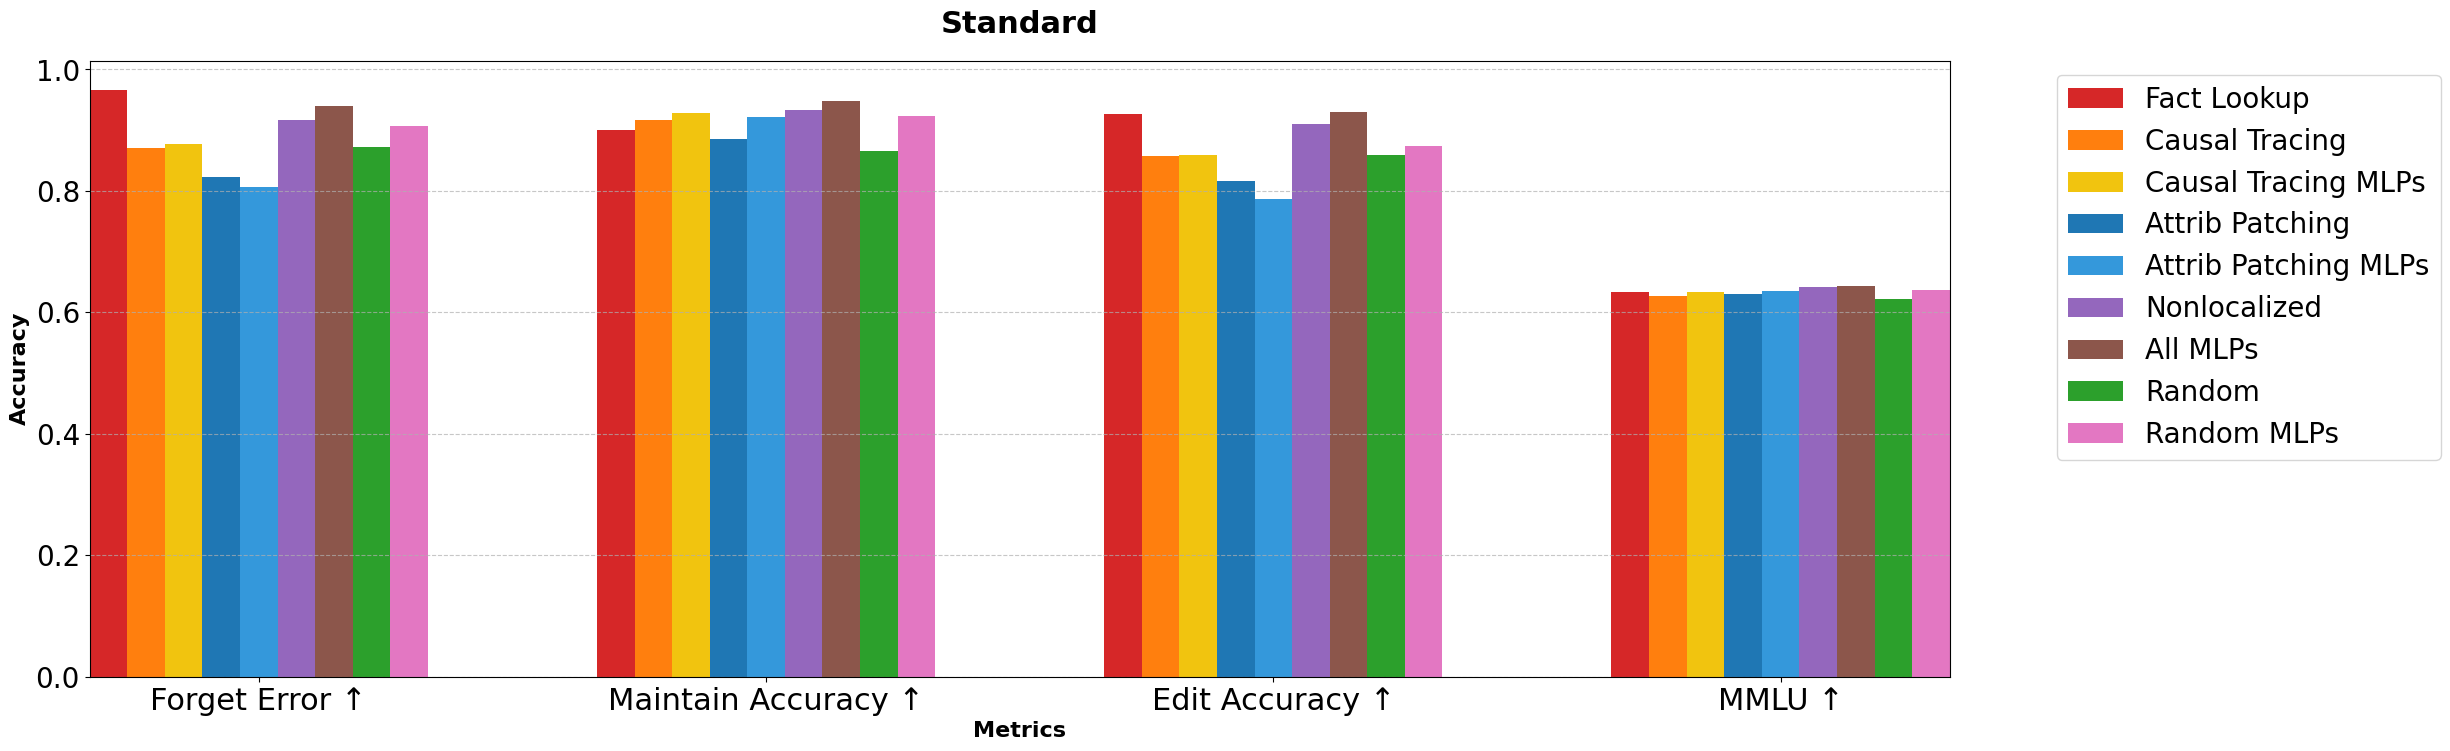

In [16]:
# colors = {"localized_ap": "#e74c3c", "localized_ct": "#2ecc71", "localized_ap_mlps": "#3498db", "localized_ct_mlps": "#f1c40f", "manual_interp": "#9b59b6", "random": "#1abc9c", "all_mlps": "#e67e22", "nonlocalized": "#e74c3c", "random_mlps": "#2ecc71"}
paper_locs = {"Manual Interp": "Fact Lookup", "Localized CT": "Causal Tracing", "Localized CT MLPs": "Causal Tracing MLPs", "Localized AP": "Attrib Patching", "Localized AP MLPs": "Attrib Patching MLPs", "Non-Localized": "Nonlocalized", "All MLPs": "All MLPs", "Random": "Random", "Random MLPs": "Random MLPs"}


include_bar_text = False
# First plot - Vanilla metrics + MMLU
plt.figure(figsize=(24, 8))
vanilla_metrics = ['Forget Error ↑', 'Maintain Accuracy ↑', 'Edit Accuracy ↑', 'MMLU ↑']
n_locs = len(paper_locs)
width = 1 / len(paper_locs)
spacing = 1.5

x1 = np.arange(0, len(vanilla_metrics) * spacing, spacing)
for idx, (loc_type, loc_name) in enumerate(paper_locs.items()):
    # Collect vanilla accuracies
    accuracies = []
    
    # vanilla forget sport accuracy
    data = test_losses_df[test_losses_df['localization_type'] == loc_type]
    forget_acc = 1 - data[data['task_name'] == 'forget_fact_accuracy']['test_loss'].mean()
    accuracies.append(forget_acc)
    
    # vanilla maintain sport accuracy
    maintain_acc = data[data['task_name'] == 'maintain_fact_accuracy']['test_loss'].mean()
    accuracies.append(maintain_acc)
    
    # vanilla edit sport accuracy
    data = adversarial_evals_df[adversarial_evals_df['eval_type'] == "Normal_Injected"]
    edit_acc = data[data['localization_type'] == loc_type]['forget'].mean()
    accuracies.append(edit_acc)
    
    # MMLU accuracy
    mmlu_acc = mmlu_evals_df[mmlu_evals_df['localization_type'] == loc_type]['mmlu'].mean()
    accuracies.append(mmlu_acc)
    
    # Plot bars
    offset = width * (idx - n_locs/2 + 0.5)
    bars = plt.bar(x1 + offset, accuracies, width, label=loc_name, color=colors[loc_type])
    
    # Add value labels
    if include_bar_text:
        for i, v in enumerate(accuracies):
            plt.text(x1[i] + offset, v, f'{v:.3f}', ha='center', va='bottom', rotation=90, fontsize=14)

plt.xlabel('Metrics', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=16, fontweight='bold')

if inject_label == '_sequential':
    title = 'Accuracies After Sequentially Editing 64 CounterFact facts'
else:
    title = 'Accuracies After Editing 16 and 64 CounterFact facts'
print(title)
title = "Standard"
plt.title(title, fontsize=22, fontweight='bold', pad=20)
plt.xticks(x1, vanilla_metrics, fontsize=22)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.xlim(min(x1) - 0.5, max(x1) + 0.5)

# Add legend
plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
plt.show()

Prompting Robustness Evaluations for Sequentially Editing CounterFact Facts


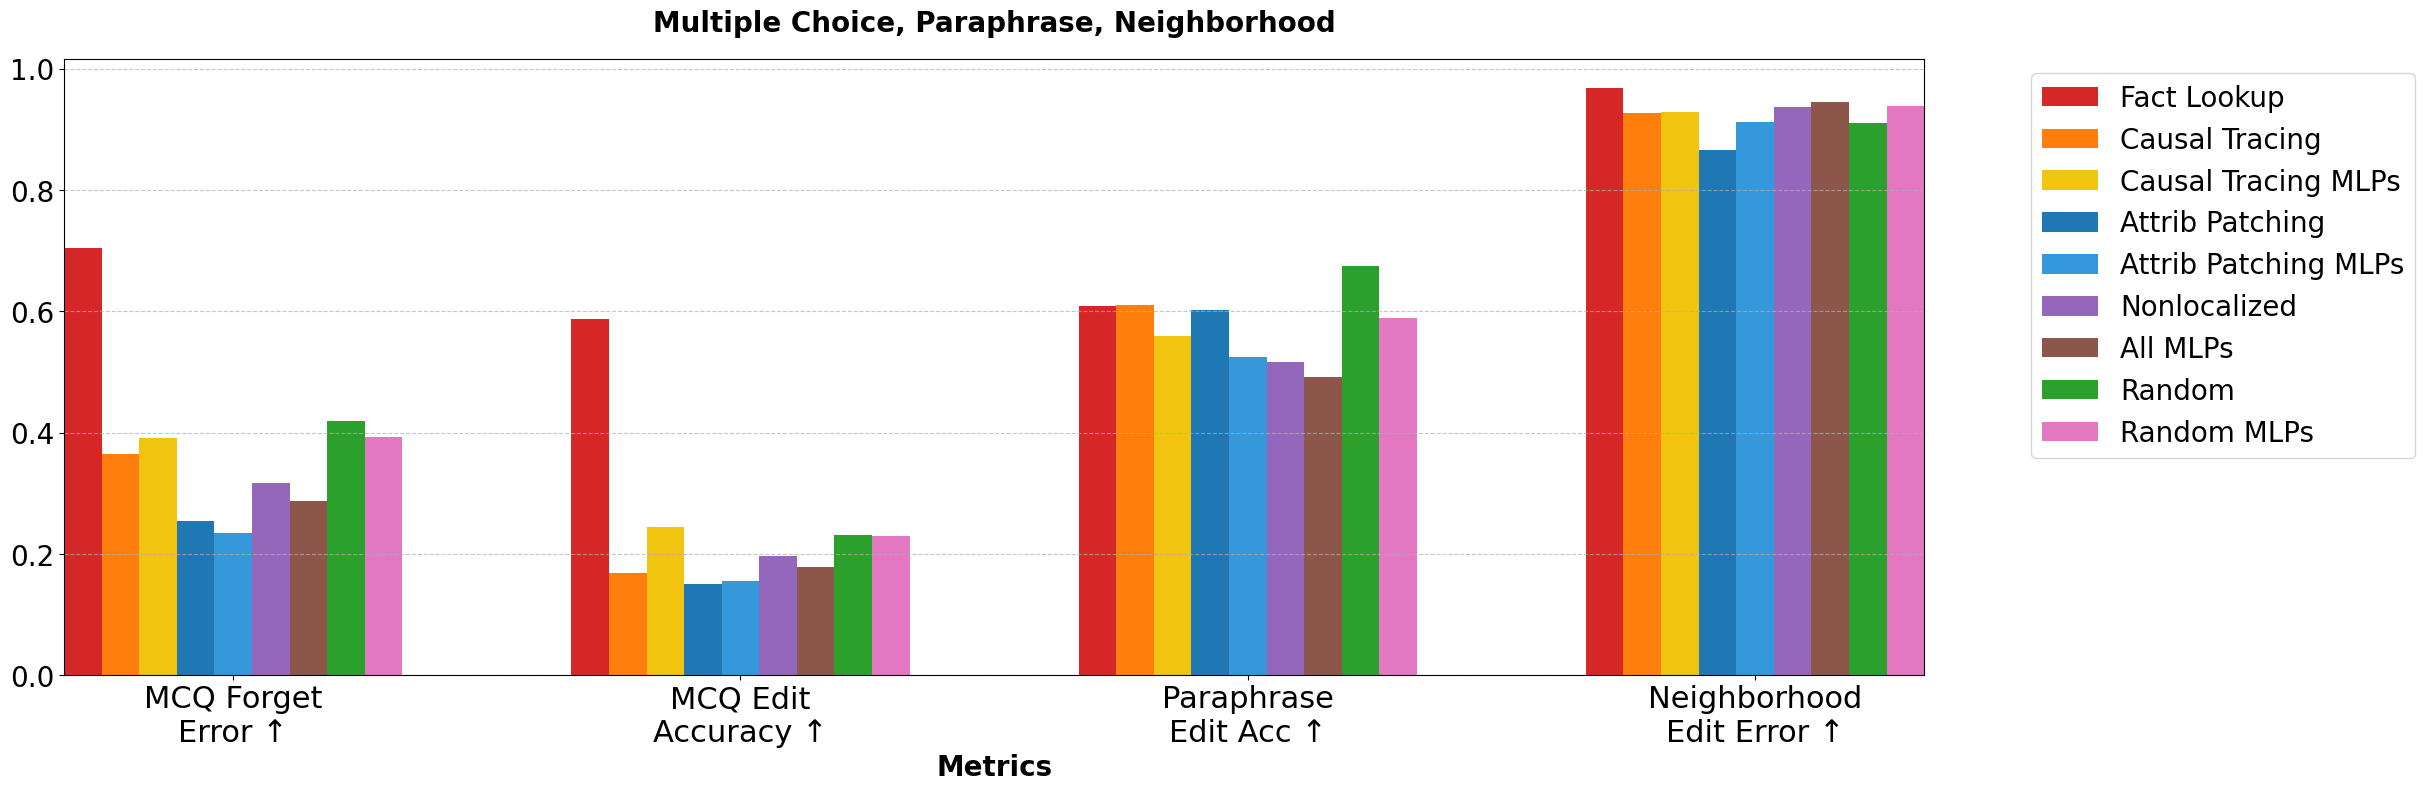

In [17]:
# Second plot - MC and Paraphrase metrics
plt.figure(figsize=(24, 8))
# robustness_metrics = ['MC Forget Accuracy ↓', 'MC Edit Accuracy ↑', 'Paraphrase Edit Acc ↑', "Neighborhood Edit Acc ↓"]
robustness_metrics = ['MCQ Forget\nError ↑', 'MCQ Edit\nAccuracy ↑', 'Paraphrase\nEdit Acc ↑', "Neighborhood\nEdit Error ↑"]

x2 = np.arange(0, len(robustness_metrics) * spacing, spacing)
for idx, (loc_type, loc_name) in enumerate(paper_locs.items()):
    # Collect robustness accuracies
    accuracies = []
    
    # MC forget accuracy
    data = adversarial_evals_df[adversarial_evals_df['eval_type'] == "MC"]
    mc_forget_acc = 1 - data[data['localization_type'] == loc_type]['forget'].mean()
    accuracies.append(mc_forget_acc)
    
    # MC edit accuracy
    data = adversarial_evals_df[adversarial_evals_df['eval_type'] == "MC_Injected"]
    mc_edit_acc = data[data['localization_type'] == loc_type]['forget'].mean()
    accuracies.append(mc_edit_acc)

    # # Paraphrase Forget
    # data = adversarial_evals_df[adversarial_evals_df['eval_type'] == "Paraphrase"]
    # paraphrase_forget_acc = data[data['localization_type'] == loc_type]['forget'].mean()
    # accuracies.append(paraphrase_forget_acc)
    
    # Paraphrase Edit
    data = adversarial_evals_df[adversarial_evals_df['eval_type'] == "Paraphrase_Injected"]
    paraphrase_edit_acc = data[data['localization_type'] == loc_type]['forget'].mean()
    accuracies.append(paraphrase_edit_acc)

    # # Neighborhood forget accuracy
    # data = adversarial_evals_df[adversarial_evals_df['eval_type'] == "Neighborhood"]
    # neighborhood_forget_acc = data[data['localization_type'] == loc_type]['forget'].mean()
    # accuracies.append(neighborhood_forget_acc)

    # Neighborhood edit accuracy
    data = adversarial_evals_df[adversarial_evals_df['eval_type'] == "Neighborhood_Injected"]
    neighborhood_edit_acc = 1 - data[data['localization_type'] == loc_type]['forget'].mean()
    accuracies.append(neighborhood_edit_acc)

    # Plot bars
    offset = width * (idx - n_locs/2 + 0.5)
    bars = plt.bar(x2 + offset, accuracies, width, label=loc_name, color=colors[loc_type])
    
    # Add value labels
    if include_bar_text:
        for i, v in enumerate(accuracies):
            plt.text(x2[i] + offset, v, f'{v:.3f}', ha='center', va='bottom', rotation=90, fontsize=14)

plt.xlabel('Metrics', fontsize=20, fontweight='bold')
# plt.ylabel('Accuracy', fontsize=16, fontweight='bold')
if inject_label == '_sequential':
    title = "Prompting Robustness Evaluations for Sequentially Editing CounterFact Facts"
else:
    title = "Prompting Robustness Evaluations for Editing CounterFact Facts"
print(title)
title = "Multiple Choice, Paraphrase, Neighborhood"
plt.title(title, fontsize=20, fontweight='bold', pad=20)
plt.xticks(x2, robustness_metrics, fontsize=22)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.xlim(min(x2) - 0.5, max(x2) + 0.5)

# Add legend
plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left') # 

# plt.tight_layout()
# Save figure before showing
# plt.savefig(f"figures/prompting/{fig_save_name}_adversarial.png", 
#             bbox_inches='tight',  # This ensures the figure is saved with proper margins
#             dpi=300)   
plt.show()

### Spider Plots

Sequential-CounterFact-Editing, counterfactsequentialedit


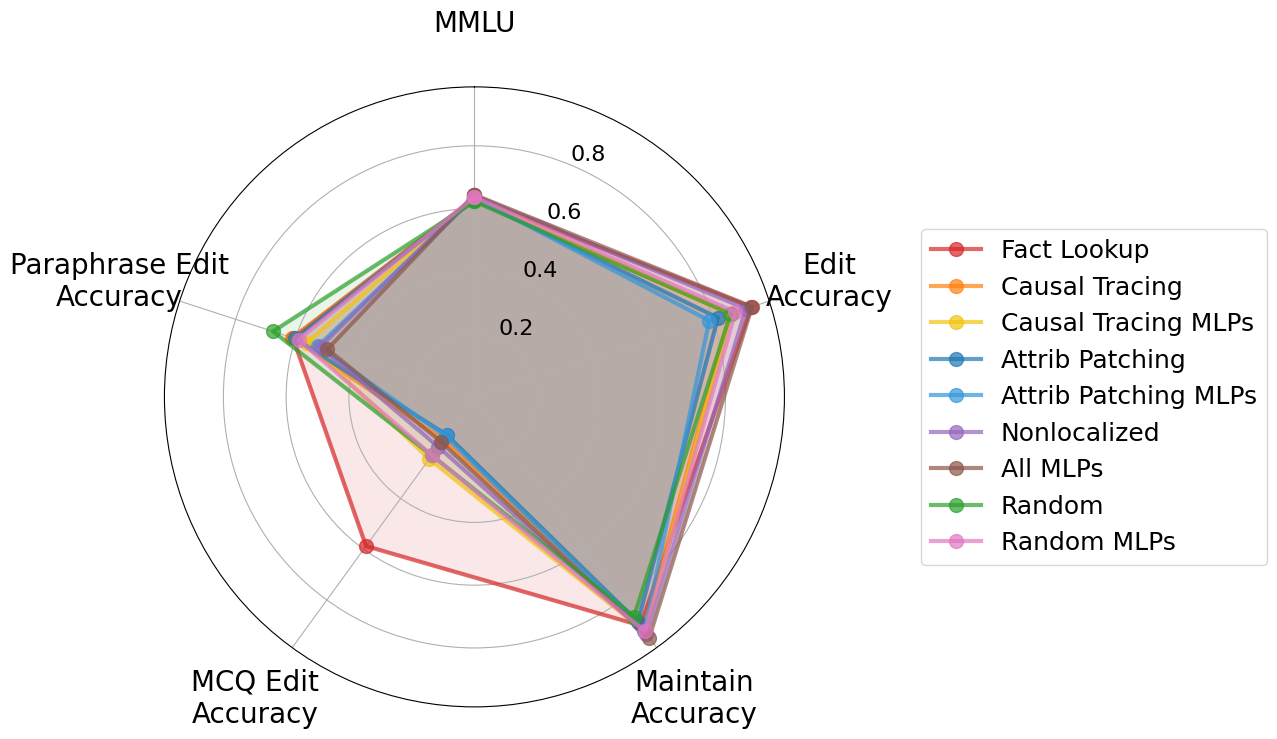

In [18]:
import numpy as np

# Create figure
use_legend = True
if use_legend:
    fig = plt.figure(figsize=(8, 30))
else:
    fig = plt.figure(figsize=(8, 15))
ax = fig.add_subplot(111, projection='polar')

# Define the metrics we want to show
metrics = ['MMLU', 'Edit\nAccuracy', 'Maintain\nAccuracy', 'MCQ Edit\nAccuracy', 'Paraphrase Edit\nAccuracy'] # , 'Neighborhood Edit\nError'
num_metrics = len(metrics)

# Calculate angles for each metric
angles = [n / float(num_metrics) * 2 * np.pi for n in range(num_metrics)]
angles += angles[:1]  # Complete the circle

# Get data for each localization type
for loc_type, loc_name in paper_locs.items():
    values = []
    
    # MMLU accuracy
    mmlu_acc = mmlu_evals_df[mmlu_evals_df['localization_type'] == loc_type]['mmlu'].mean()
    values.append(mmlu_acc)
    
    # Vanilla edit accuracy
    data = adversarial_evals_df[adversarial_evals_df['eval_type'] == "Normal_Injected"]
    edit_acc = data[data['localization_type'] == loc_type]['forget'].mean()
    values.append(edit_acc)
    
    # Maintain accuracy
    data = test_losses_df[test_losses_df['localization_type'] == loc_type]
    maintain_acc = data[data['task_name'] == 'maintain_fact_accuracy']['test_loss'].mean()
    values.append(maintain_acc)
    
    # MC edit accuracy
    data = adversarial_evals_df[adversarial_evals_df['eval_type'] == "MC_Injected"]
    mc_edit_acc = data[data['localization_type'] == loc_type]['forget'].mean()
    values.append(mc_edit_acc)
    
    # Paraphrase edit accuracy
    data = adversarial_evals_df[adversarial_evals_df['eval_type'] == "Paraphrase_Injected"]
    paraphrase_edit_acc = data[data['localization_type'] == loc_type]['forget'].mean()
    values.append(paraphrase_edit_acc)

    # Neighborhood Edit Error
    # data = adversarial_evals_df[adversarial_evals_df['eval_type'] == "Neighborhood_Injected"]
    # neighorhood_edit_acc = 1 - data[data['localization_type'] == loc_type]['forget'].mean()
    # values.append(neighorhood_edit_acc)
    
    # Complete the circle
    values += values[:1]
    
    # Plot the values
    ax.plot(angles, values, 'o-', markersize=10, linewidth=3, label=loc_name, color=colors[loc_type], alpha=0.7)
    ax.fill(angles, values, alpha=0.1, color=colors[loc_type])

# Fix axis to go in the right order and start at the top
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=20)

# Increase the spacing between labels and plot
ax.tick_params(pad=35)

# Set ytick font size
ax.tick_params(axis='y', labelsize=16)

# Add legend
if use_legend:
    plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), fontsize=18)

if inject_label == '_sequential':
    print("Sequential-CounterFact-Editing, counterfactsequentialedit")
    # plt.title('Sequential-CounterFact-Editing', fontsize=16, pad=20)
else:
    print("CounterFact-Editing, counterfactedit")
    # plt.title('CounterFact-Editing', fontsize=16, pad=20)

# Adjust layout to prevent label cutoff
# plt.tight_layout()

plt.show()

### Relearning

CounterFact Forget Accuracy Recovered by Relearning


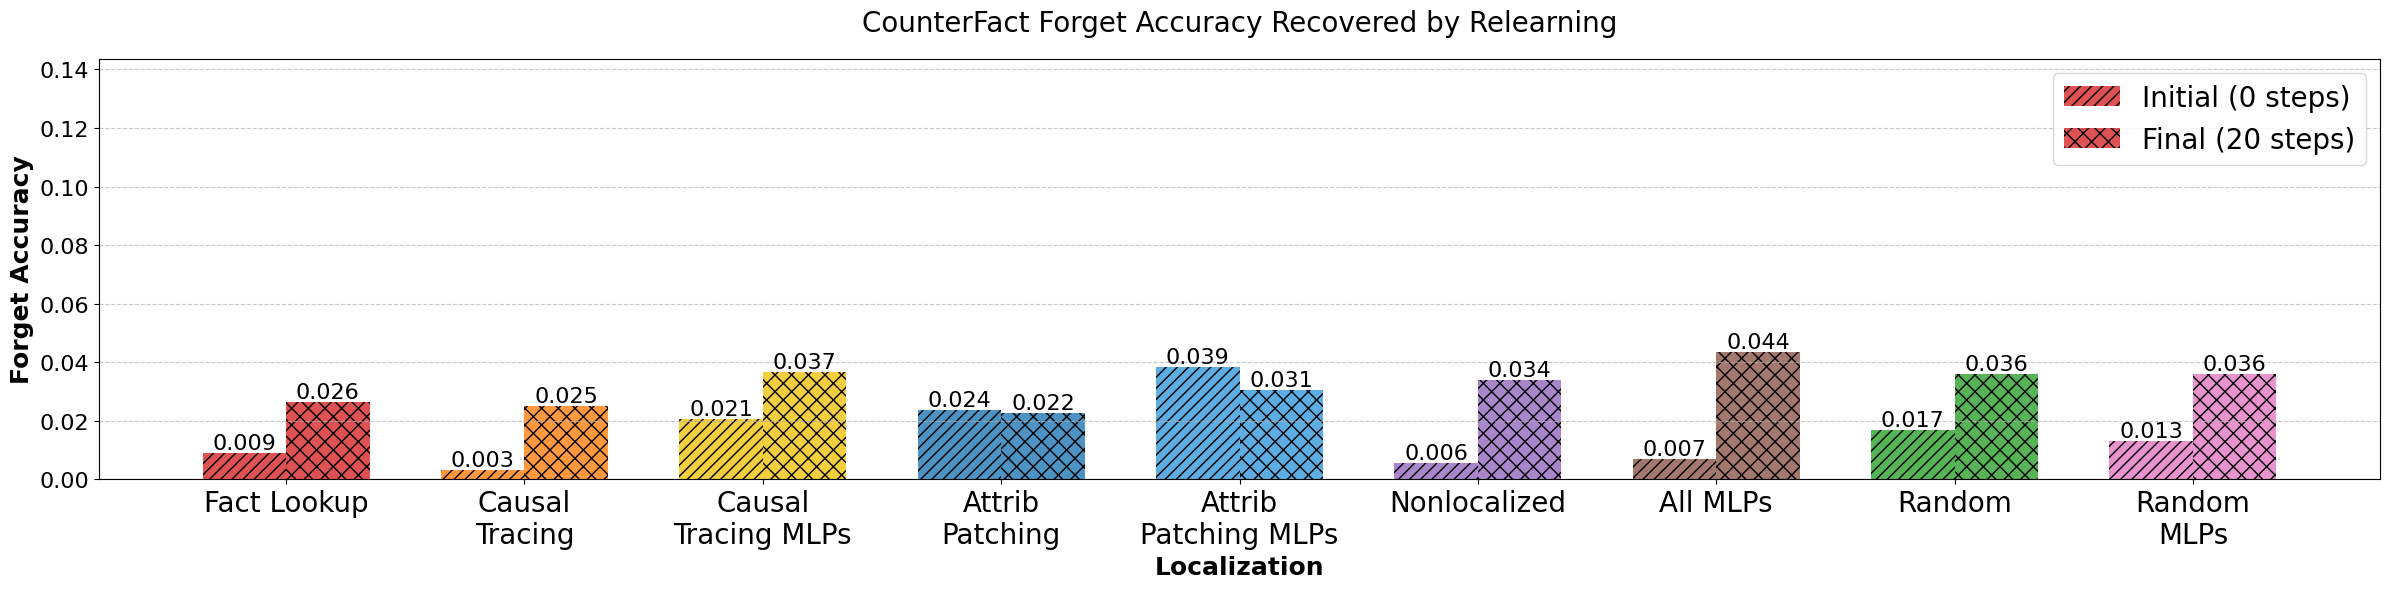

In [19]:
# Create figure
plt.figure(figsize=(24, 6))

# Width of each bar and spacing between groups
bar_width = 0.35
loc_types = list(paper_locs.keys())
x = np.arange(len(loc_types))

# Collect initial and final accuracies
initial_accuracies = []
final_accuracies = []

for loc_type in loc_types:
    data = relearning_evals_df[relearning_evals_df['localization_type'] == loc_type]
    
    # Get initial accuracy (step 0)
    initial_acc = data[data['step'] == 0]['Normal_forget'].mean()
    initial_accuracies.append(initial_acc)
    
    # Get final accuracy (step 20)
    final_acc = data[data['step'] == 20]['Normal_forget'].mean()
    final_accuracies.append(final_acc)

# Create bars with patterns
for i, loc_type in enumerate(loc_types):
    # Initial accuracy bar with diagonal pattern
    initial_bar = plt.bar(x[i] - bar_width/2, initial_accuracies[i], bar_width, 
            label='Initial (0 steps)' if i == 0 else "", 
            color=colors[loc_type],
            hatch='///',
            alpha=0.8)
    
    # Final accuracy bar with crosshatch pattern
    final_bar = plt.bar(x[i] + bar_width/2, final_accuracies[i], bar_width,
            label='Final (20 steps)' if i == 0 else "",
            color=colors[loc_type],
            hatch='xx',
            alpha=0.8)
    
    # Add value labels above bars
    plt.text(x[i] - bar_width/2, initial_accuracies[i], f'{initial_accuracies[i]:.3f}', 
             ha='center', va='bottom', fontsize=16)
    plt.text(x[i] + bar_width/2, final_accuracies[i], f'{final_accuracies[i]:.3f}', 
             ha='center', va='bottom', fontsize=16)

# Customize plot
plt.xlabel('Localization', fontsize=18, fontweight='bold')
plt.ylabel('Forget Accuracy', fontsize=18, fontweight='bold')
if "random_without_golf" in inject_labels:
    title = 'CounterFact Forget Accuracy Recovered by Relearning'
else:
    title = 'CounterFact Forget Accuracy Recovered by Relearning'
print(title)
plt.title(title, fontsize=20, pad=20)

# Set x-axis labels
paper_loc_names_with_newlines = {"Localized AP": "Attrib\nPatching", "Localized CT": "Causal\nTracing", 'Localized AP MLPs': "Attrib\nPatching MLPs",
       'Localized CT MLPs': "Causal\nTracing MLPs", 'Manual Interp': "Fact Lookup", 'Random': "Random", 'All MLPs': "All MLPs",
       'Non-Localized': "Nonlocalized", 'Random MLPs': "Random\nMLPs"}
plt.xticks(x, [paper_loc_names_with_newlines[loc] for loc in loc_types], fontsize=20)
plt.yticks(fontsize=16)
plt.ylim(0, max(final_accuracies) + 0.1)
# Add grid
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Add legend
plt.legend(fontsize=20)

# Adjust layout
plt.tight_layout()

plt.show()

### Softprompt

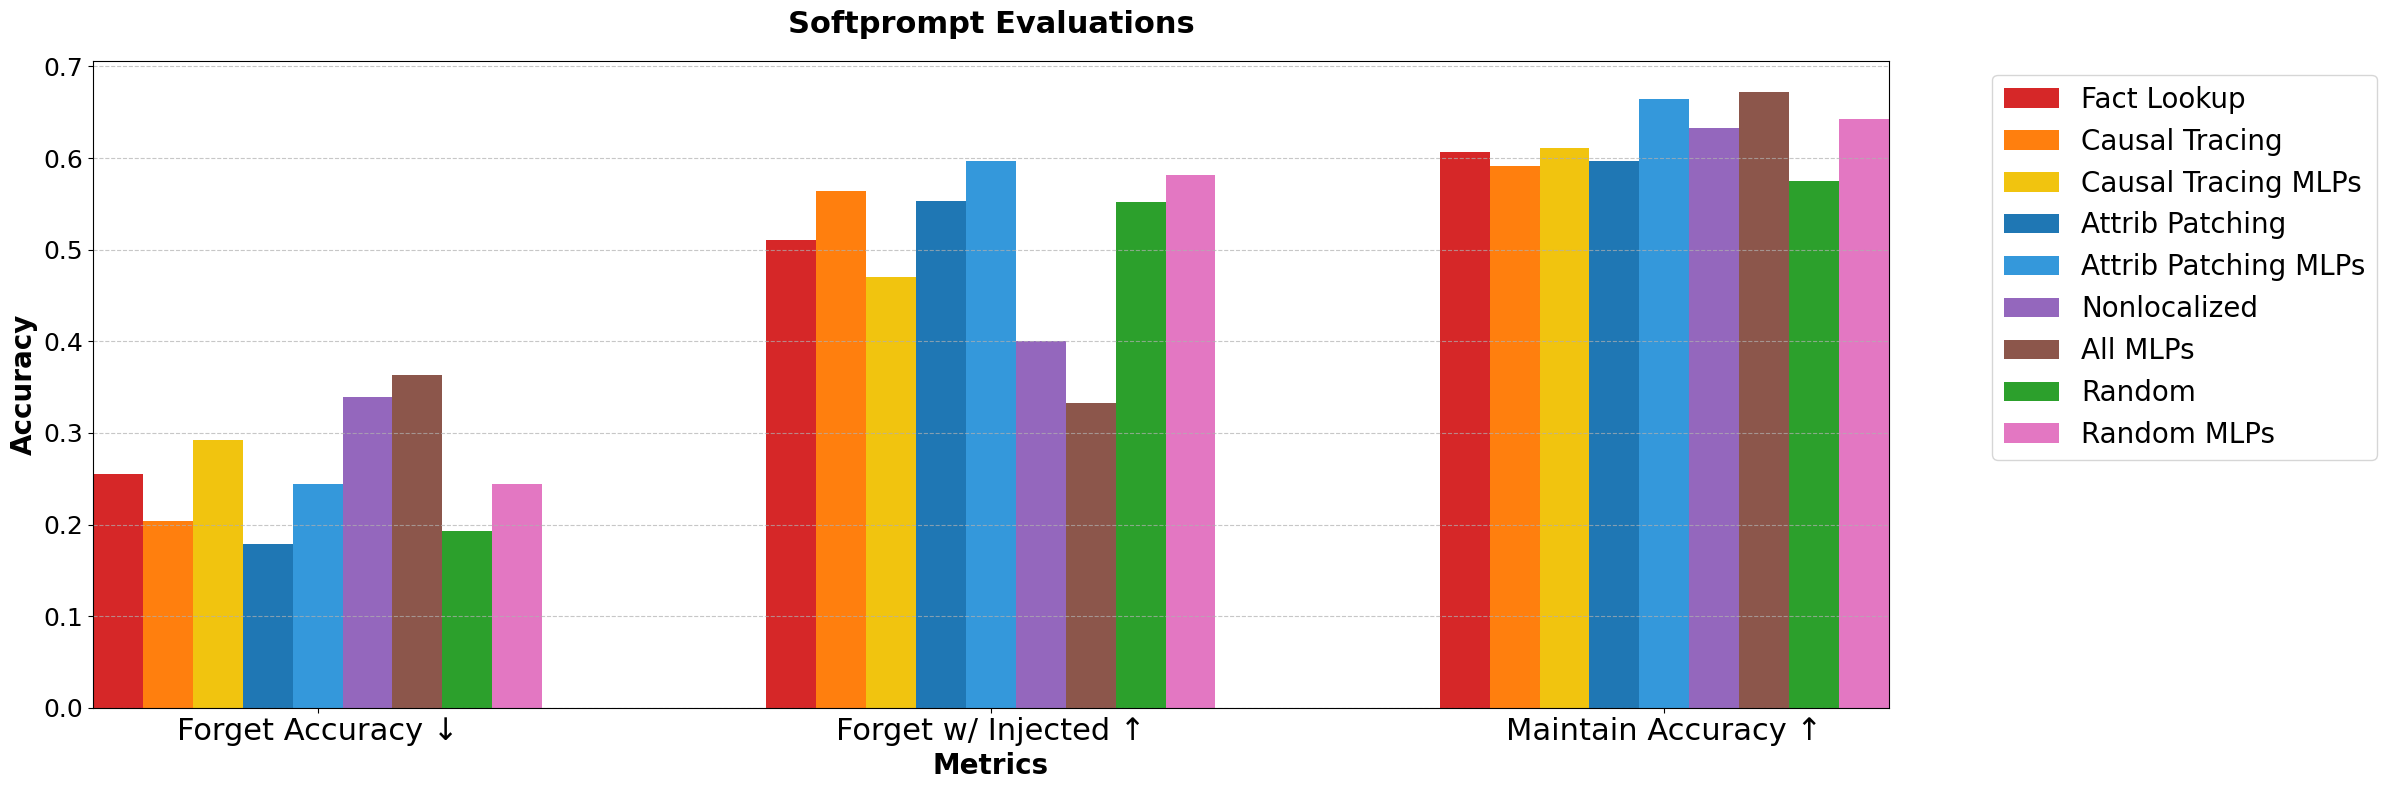

In [20]:
# Create single large figure
plt.figure(figsize=(24, 8))

# Define metrics and spacing
softprompt_metrics = ['Forget Accuracy ↓', 'Forget w/ Injected ↑', 'Maintain Accuracy ↑']
n_locs = len(paper_locs)
width = 1 / len(paper_locs)
spacing = 1.5

x = np.arange(0, len(softprompt_metrics) * spacing, spacing)

# Plot bars for each localization type
for idx, (loc_type, loc_name) in enumerate(paper_locs.items()):
    # Collect accuracies
    accuracies = []
    data = softprompt_evals_df[softprompt_evals_df['localization_type'] == loc_type]
    
    # Get the three metrics
    forget_acc = data['forget_acc'].mean()
    forget_injected_acc = data['forget_acc_with_injected'].mean()
    maintain_acc = data['maintain_acc'].mean()
    
    accuracies = [forget_acc, forget_injected_acc, maintain_acc]
    
    # Plot bars
    offset = width * (idx - n_locs/2 + 0.5)
    bars = plt.bar(x + offset, accuracies, width, label=loc_name, color=colors[loc_type])
    
    # Add value labels if needed
    if include_bar_text:
        for i, v in enumerate(accuracies):
            plt.text(x[i] + offset, v, f'{v:.3f}', ha='center', va='bottom', rotation=90, fontsize=14)

plt.xlabel('Metrics', fontsize=20, fontweight='bold')
plt.ylabel('Accuracy', fontsize=20, fontweight='bold')
plt.title("Softprompt Evaluations", fontsize=22, fontweight='bold', pad=20)

plt.xticks(x, softprompt_metrics, fontsize=22)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.xlim(min(x) - 0.5, max(x) + 0.5)

# Add legend
plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

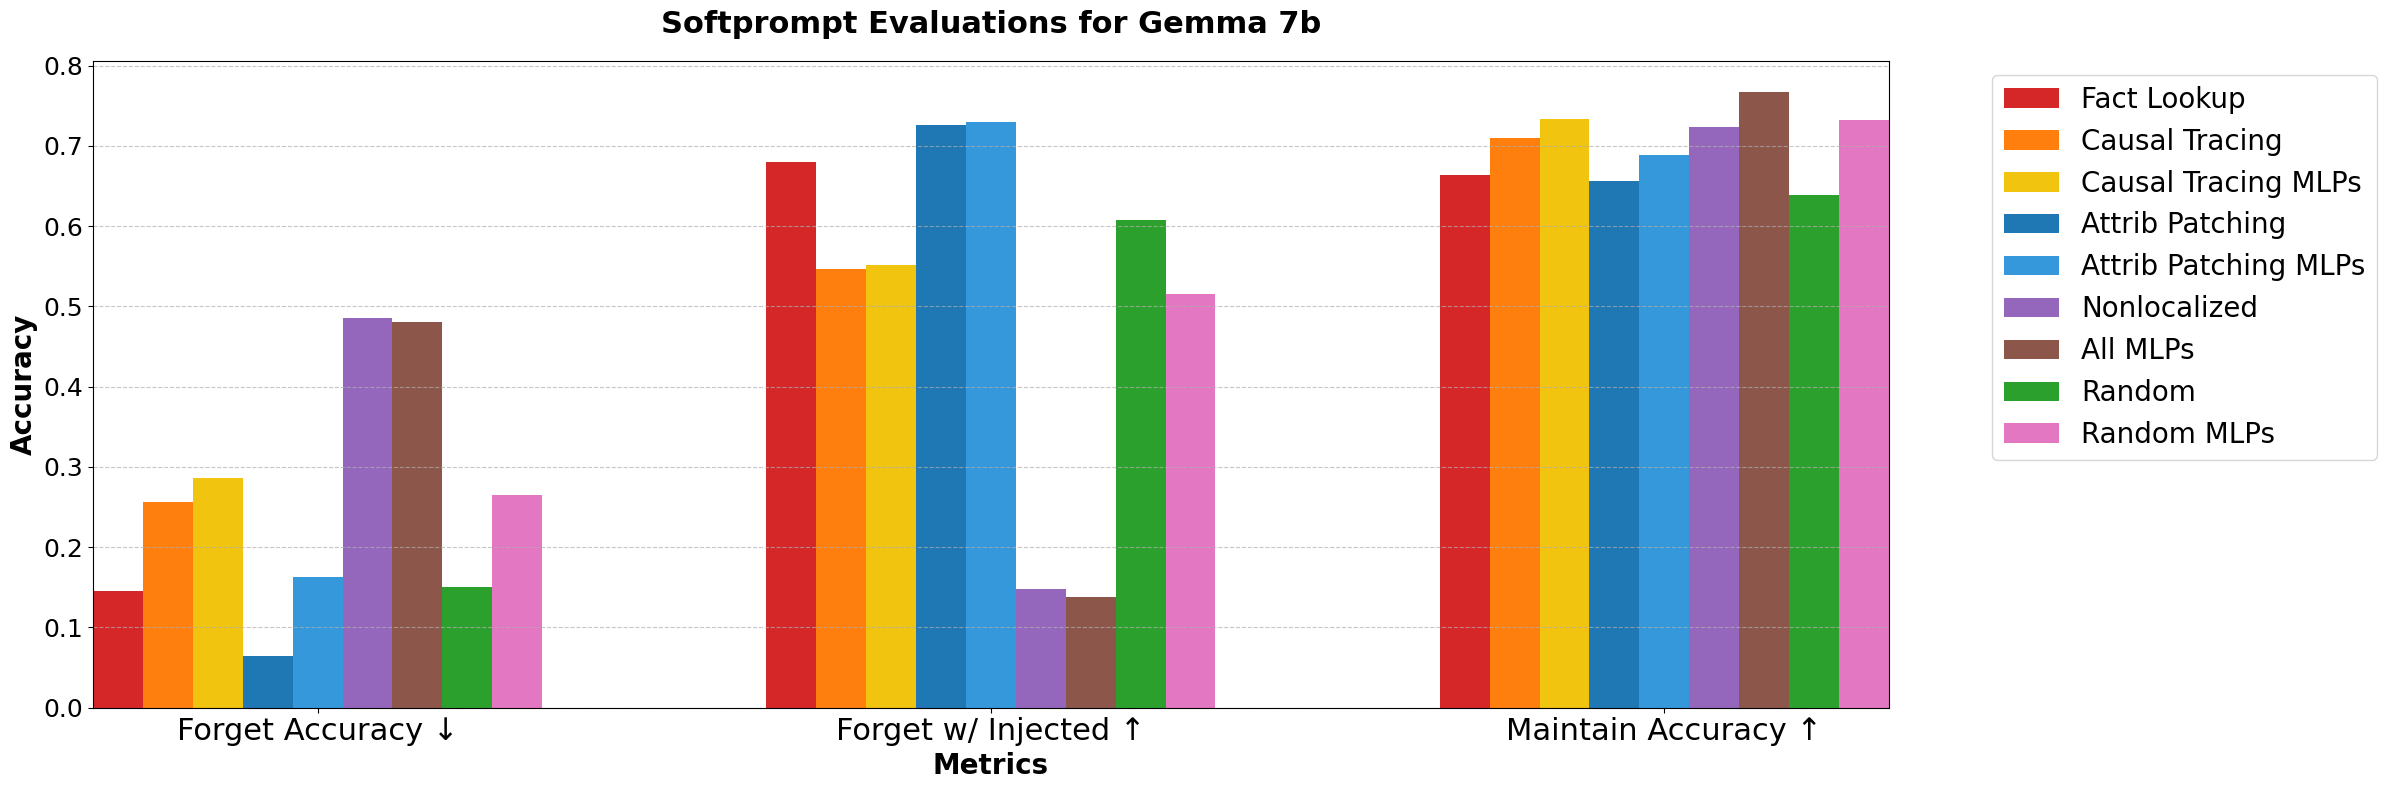

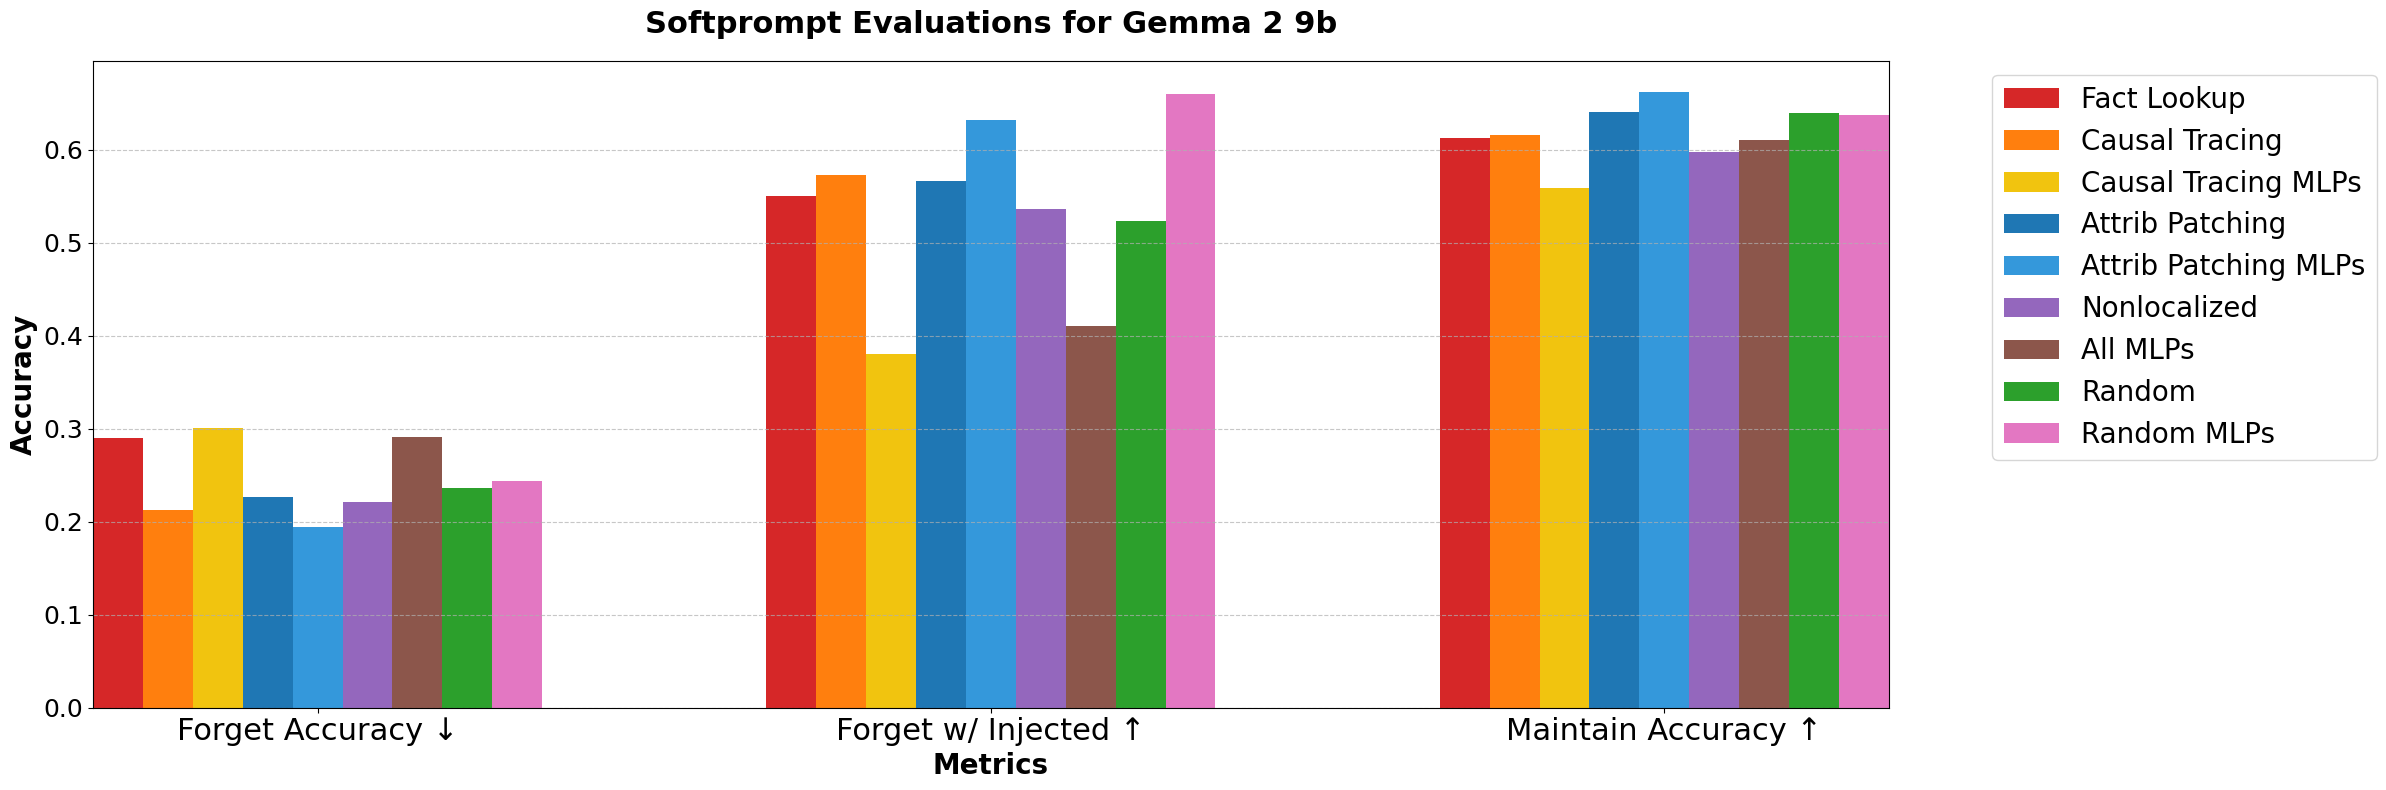

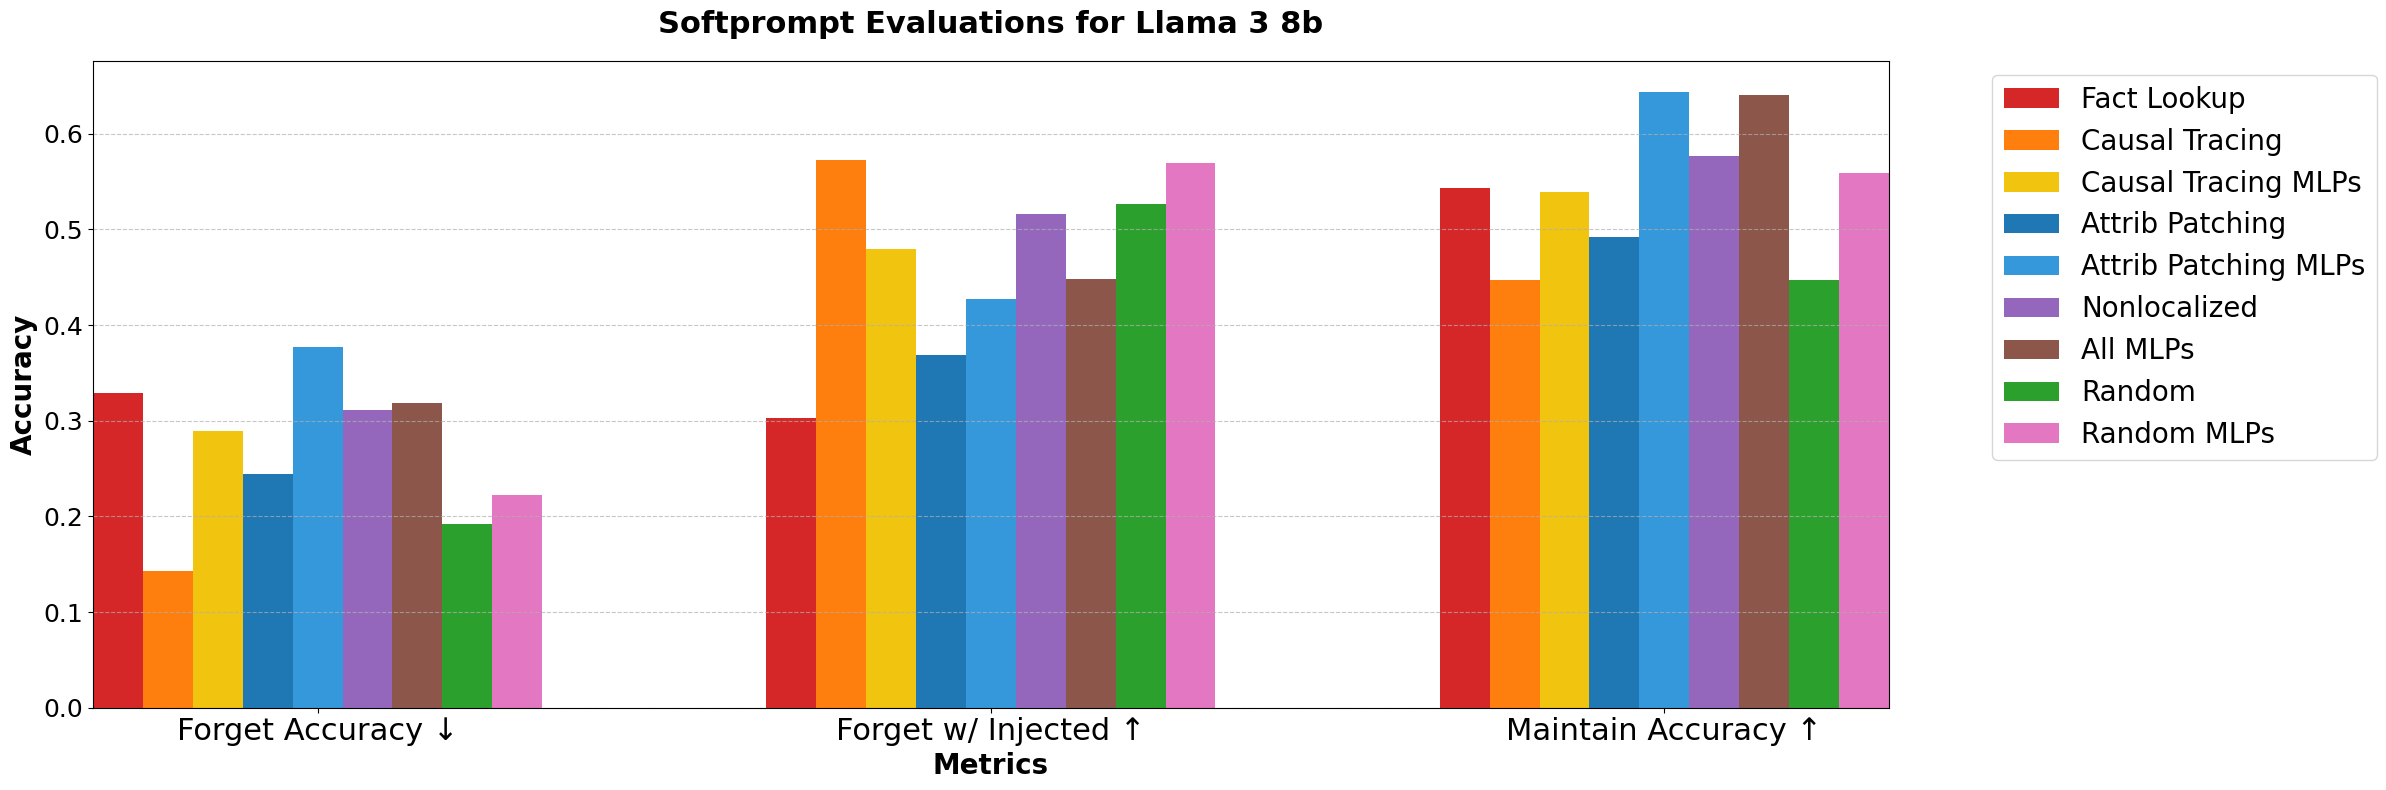

In [21]:
# Create single large figure
for model_type in model_names:
    plt.figure(figsize=(24, 8))

    # Define metrics and spacing
    softprompt_metrics = ['Forget Accuracy ↓', 'Forget w/ Injected ↑', 'Maintain Accuracy ↑']
    n_locs = len(paper_locs)
    width = 1 / len(paper_locs)
    spacing = 1.5

    x = np.arange(0, len(softprompt_metrics) * spacing, spacing)

    # Plot bars for each localization type
    for idx, (loc_type, loc_name) in enumerate(paper_locs.items()):
        # Collect accuracies
        accuracies = []
        data = softprompt_evals_df[softprompt_evals_df['localization_type'] == loc_type]
        data = data[data['model_name'] == model_type]
        
        # Get the three metrics
        forget_acc = data['forget_acc'].mean()
        forget_injected_acc = data['forget_acc_with_injected'].mean()
        maintain_acc = data['maintain_acc'].mean()
        
        accuracies = [forget_acc, forget_injected_acc, maintain_acc]
        
        # Plot bars
        offset = width * (idx - n_locs/2 + 0.5)
        bars = plt.bar(x + offset, accuracies, width, label=loc_name, color=colors[loc_type])
        
        # Add value labels if needed
        if include_bar_text:
            for i, v in enumerate(accuracies):
                plt.text(x[i] + offset, v, f'{v:.3f}', ha='center', va='bottom', rotation=90, fontsize=14)

    plt.xlabel('Metrics', fontsize=20, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=20, fontweight='bold')
    plt.title(f"Softprompt Evaluations for {model_names[model_type]}", fontsize=22, fontweight='bold', pad=20)

    plt.xticks(x, softprompt_metrics, fontsize=22)
    plt.yticks(fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.xlim(min(x) - 0.5, max(x) + 0.5)

    # Add legend
    plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()